# **Map-reduce**
Now, we're going to cover map reduce.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# **Problem**
Map-reduce operations are essential for efficient task decomposition and parallel processing.

It has two phases:

(1) Map - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) Reduce - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) Map - Create a set of jokes about a topic.

(2) Reduce - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [2]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# **State**
Parallelizing joke generation
First, let's define the entry point of the graph that will:

Take a user input topic
Produce a list of joke topics from it
Send each joke topic to our above joke generation node
Our state has a jokes key, which will accumulate jokes from parallelized joke generation

In [3]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

Generate subjects for jokes.

In [4]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the Send to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

generate_joke: the name of the node in the graph
{"subject": s}: the state to send
Send allow you to pass any state that you want to generate_joke! It does not have to align with OverallState.

In this case, generate_joke is using its own internal state, and we can populate this via Send.

In [5]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

# **Joke generation (map)**
Now, we just define a node that will create our jokes, generate_joke!

We write them back out to jokes in OverallState!

This key has a reducer that will combine lists.

In [6]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

# **Best joke selection (reduce)**
Now, we add logic to pick the best joke.

In [7]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

# **Compile**

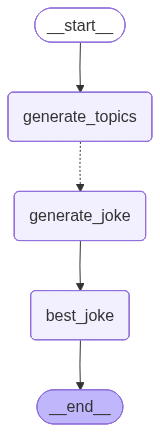

In [8]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [9]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior and Communication', 'Conservation and Endangered Species', 'Animal Habitats and Ecosystems']}}
{'generate_joke': {'jokes': ['Why did the squirrel bring a suitcase to the forest?\n\nBecause it heard the ecosystem was "tree-mendous" and wanted to branch out!']}}
{'generate_joke': {'jokes': ['Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!']}}
{'generate_joke': {'jokes': ['Why did the endangered species start a band?\n\nBecause they wanted to make some noise before they went extinct!']}}
{'best_joke': {'best_selected_joke': 'Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!'}}
